In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


# Prepare Train_Test Data

In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

train_y = train['target']
train_data = train.drop(columns=['id', 'target'])
test_data = test.drop(columns=['id'])

train_rows_len = train_data.shape[0]

train_test_data = pd.concat([train_data, test_data])

print(train_data.shape)
print(test_data.shape)
print(train_test_data.shape)

(300000, 30)
(200000, 30)
(500000, 30)


# Plot Target Data

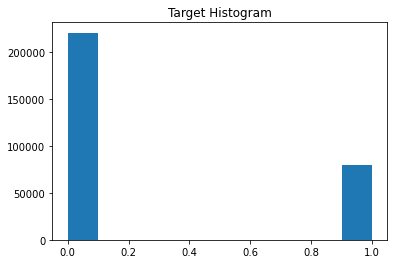

In [3]:
import matplotlib.pyplot as plt

plt.hist(train_y)
plt.title("Target Histogram")
plt.show()

# Split Numerical and Categorical

In [4]:
data_categorical_pd  = train_test_data.loc[:,train_test_data.dtypes==np.object]
data_numerical_pd  = train_test_data.loc[:,train_test_data.dtypes!=np.object]
print('data_categorical_pd.shape: ', data_categorical_pd.shape)
print('data_numerical_pd.shape: ', data_numerical_pd.shape)

data_categorical_pd.shape:  (500000, 19)
data_numerical_pd.shape:  (500000, 11)


# Data cleaning - Dealing with null values

In [5]:
categorical_missing_val_count = (data_categorical_pd.isnull().sum())
numerical_missing_val_count = (data_numerical_pd.isnull().sum())

print('categorical_missing_val_count')
print(categorical_missing_val_count[categorical_missing_val_count > 0])
print('numerical_missing_val_count')
print(numerical_missing_val_count[numerical_missing_val_count > 0])

categorical_missing_val_count
Series([], dtype: int64)
numerical_missing_val_count
Series([], dtype: int64)


# Data cleaning - Dealing with outliers

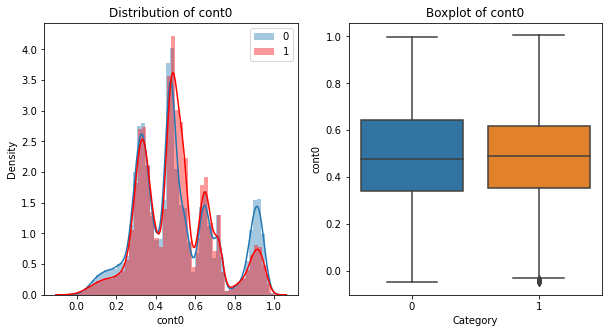

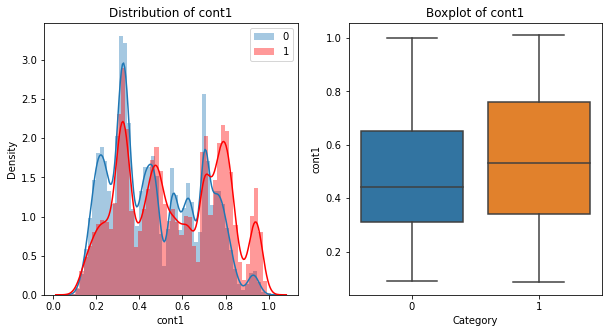

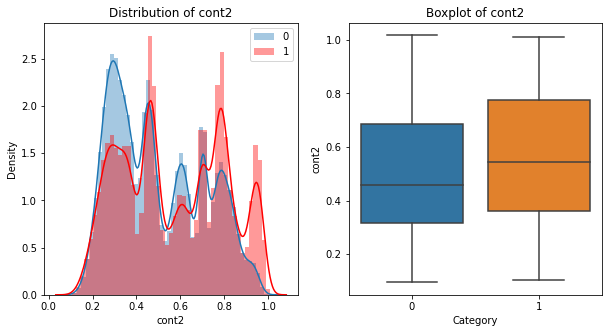

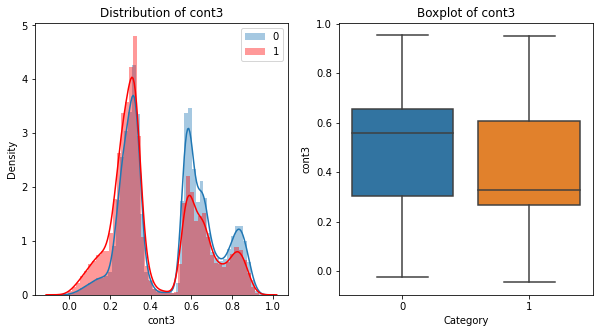

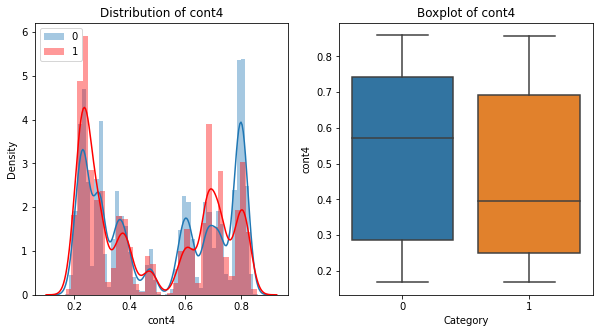

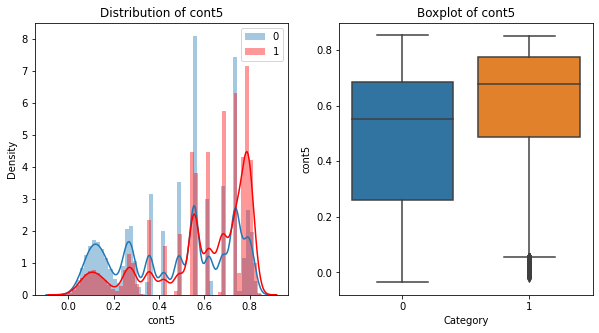

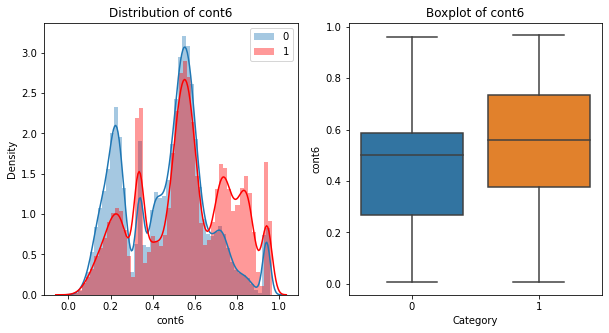

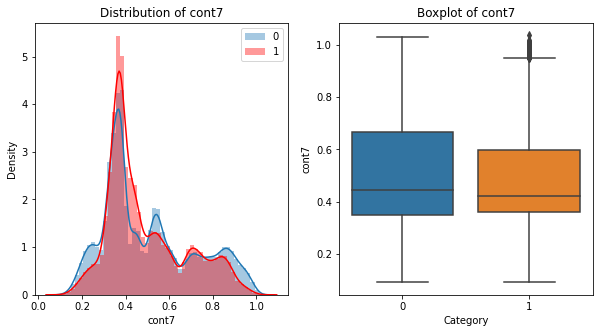

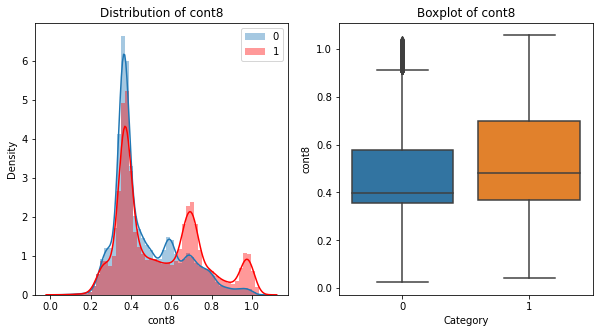

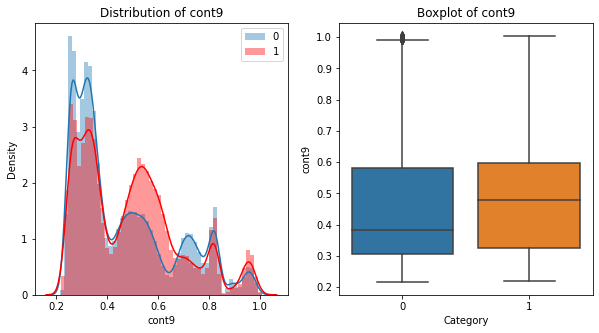

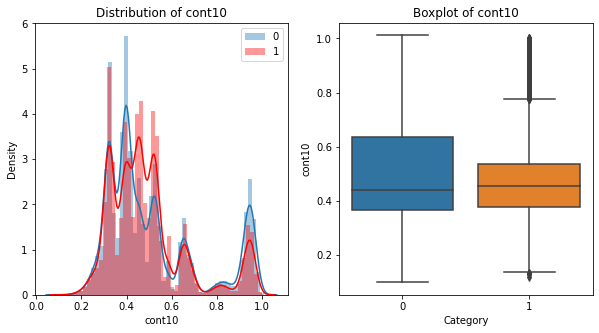

In [6]:
import seaborn as sns
import warnings

warnings.simplefilter("ignore")

# Numerical
y_plot = train_y.copy()
y_plot.columns = ['target']
Data_plot = pd.concat([data_numerical_pd[:][:len(y_plot)], y_plot], axis=1)

for feature in data_numerical_pd.columns:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    plot10 = sns.distplot(Data_plot[Data_plot['target']==0][feature],ax=ax1, label='0')
    sns.distplot(Data_plot[Data_plot['target']==1][feature],ax=ax1,color='red', label='1')
    plot10.axes.legend()
    ax1.set_title('Distribution of {name}'.format(name=feature))

    sns.boxplot(x='target',y=feature,data=Data_plot,ax=ax2)
    ax2.set_xlabel('Category') 
    ax2.set_title('Boxplot of {name}'.format(name=feature))

    fig.show()

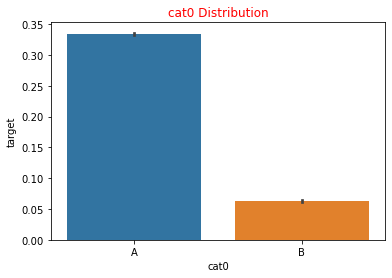

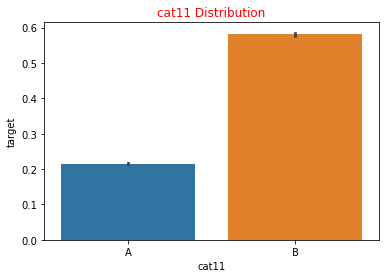

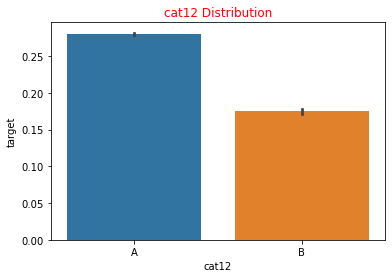

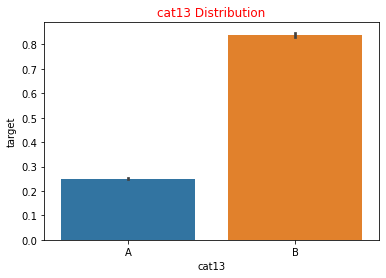

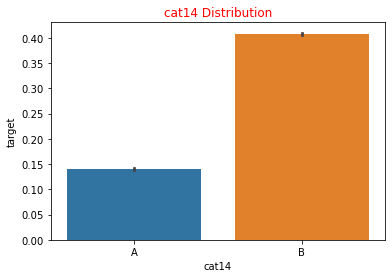

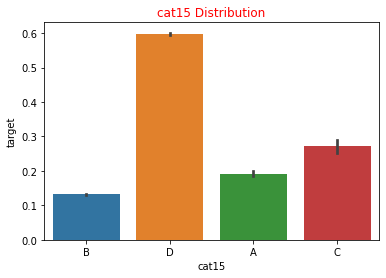

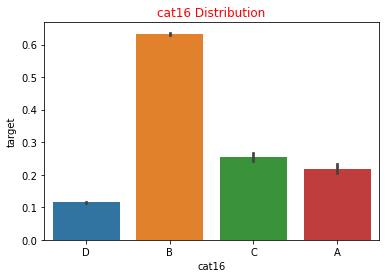

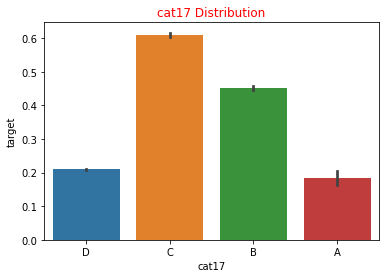

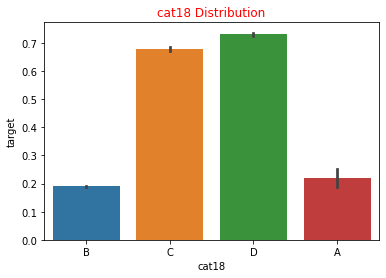

In [7]:
data_plot = pd.concat([data_categorical_pd[:][:len(y_plot)], y_plot], axis=1)

for feature in data_categorical_pd.columns:
    if len(data_categorical_pd[feature].unique()) > 10:
        continue
    plt.figure()
    plt.title(feature + ' Distribution', color = 'red')
    sns.barplot(x=feature, y='target', data = data_plot)
    plt.show()

# Data cleaning - Label encoding, Drop Constant

In [8]:
from sklearn.model_selection import train_test_split

object_cols = data_categorical_pd.columns
X_train, X_valid, y_train, y_valid = train_test_split(data_categorical_pd[:][:len(train_y)], train_y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

print('good_label_cols: ', len(good_label_cols))
print(good_label_cols)
print('bad_label_cols: ', len(bad_label_cols))
print(bad_label_cols)

good_label_cols:  18
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
bad_label_cols:  1
['cat10']


In [9]:
th = 100

cat10_counts = data_categorical_pd['cat10'].value_counts()
cat10_cut_values = cat10_counts[cat10_counts > th].index
print('cat10_cut_values: ', len(cat10_cut_values))

cat10_cut_values_list = []
for value in data_categorical_pd['cat10']:
    if value in cat10_cut_values:
        cat10_cut_values_list.append(value)
    else:
        cat10_cut_values_list.append('others')

data_categorical_temp_pd = data_categorical_pd.copy()
data_categorical_temp_pd['cat10'] = cat10_cut_values_list

object_cols = data_categorical_temp_pd.columns
X_train, X_valid, y_train, y_valid = train_test_split(data_categorical_temp_pd[:][:len(train_y)], train_y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

print('cat10: ', set(X_train['cat10']) == set(X_valid['cat10']))

cat10_cut_values:  186
cat10:  True


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data_categorical_encoded_pd = data_categorical_temp_pd.copy()
for feature in data_categorical_encoded_pd.columns:
        le = LabelEncoder()
        data_categorical_encoded_pd[feature] = le.fit_transform(data_categorical_temp_pd[feature].astype(str))
        
print(data_categorical_encoded_pd.info())
print(data_numerical_pd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   cat0    500000 non-null  int64
 1   cat1    500000 non-null  int64
 2   cat2    500000 non-null  int64
 3   cat3    500000 non-null  int64
 4   cat4    500000 non-null  int64
 5   cat5    500000 non-null  int64
 6   cat6    500000 non-null  int64
 7   cat7    500000 non-null  int64
 8   cat8    500000 non-null  int64
 9   cat9    500000 non-null  int64
 10  cat10   500000 non-null  int64
 11  cat11   500000 non-null  int64
 12  cat12   500000 non-null  int64
 13  cat13   500000 non-null  int64
 14  cat14   500000 non-null  int64
 15  cat15   500000 non-null  int64
 16  cat16   500000 non-null  int64
 17  cat17   500000 non-null  int64
 18  cat18   500000 non-null  int64
dtypes: int64(19)
memory usage: 76.3 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 199999
Data colum

# Feature Engineering

In [11]:
for feature in data_categorical_encoded_pd.columns:
    value = len(data_categorical_encoded_pd[feature].unique())
    print(feature, value)

same_len_19 = ['cat9', 'cat2']
same_len_4 = ['cat15', 'cat16', 'cat17', 'cat18']
same_len_2 = ['cat0', 'cat11', 'cat12', 'cat13', 'cat14']

cat0 2
cat1 15
cat2 19
cat3 13
cat4 20
cat5 84
cat6 16
cat7 51
cat8 61
cat9 19
cat10 187
cat11 2
cat12 2
cat13 2
cat14 2
cat15 4
cat16 4
cat17 4
cat18 4


In [12]:
data_categorical_FeaEng_pd = data_categorical_encoded_pd.copy()
data_numerical_FeaEng_pd = data_numerical_pd.copy()

data_categorical_FeaEng_pd['cat9cat2T'] = data_categorical_encoded_pd['cat9'] + data_categorical_encoded_pd['cat2']
data_categorical_FeaEng_pd['cat9cat2M'] = data_categorical_encoded_pd['cat9'] * data_categorical_encoded_pd['cat2']

data_categorical_FeaEng_pd['cat15cat16T'] = data_categorical_encoded_pd['cat15'] + data_categorical_encoded_pd['cat16']
data_categorical_FeaEng_pd['cat15cat17T'] = data_categorical_encoded_pd['cat15'] + data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat15cat18T'] = data_categorical_encoded_pd['cat15'] + data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat16cat17T'] = data_categorical_encoded_pd['cat16'] + data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat16cat18T'] = data_categorical_encoded_pd['cat16'] + data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat17cat18T'] = data_categorical_encoded_pd['cat17'] + data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat15cat16M'] = data_categorical_encoded_pd['cat15'] * data_categorical_encoded_pd['cat16']
data_categorical_FeaEng_pd['cat15cat17M'] = data_categorical_encoded_pd['cat15'] * data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat15cat18M'] = data_categorical_encoded_pd['cat15'] * data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat16cat17M'] = data_categorical_encoded_pd['cat16'] * data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat16cat18M'] = data_categorical_encoded_pd['cat16'] * data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat17cat18M'] = data_categorical_encoded_pd['cat17'] * data_categorical_encoded_pd['cat18']

data_categorical_FeaEng_pd['cat0cat11T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat11']
data_categorical_FeaEng_pd['cat0cat12T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat0cat13T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat0cat14T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat11cat12T'] = data_categorical_encoded_pd['cat11'] + data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat11cat13T'] = data_categorical_encoded_pd['cat11'] + data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat11cat14T'] = data_categorical_encoded_pd['cat11'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat12cat13T'] = data_categorical_encoded_pd['cat12'] + data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat12cat14T'] = data_categorical_encoded_pd['cat12'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat13cat14T'] = data_categorical_encoded_pd['cat13'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat0cat11M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat11']
data_categorical_FeaEng_pd['cat0cat12M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat0cat13M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat0cat14M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat11cat12M'] = data_categorical_encoded_pd['cat11'] * data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat11cat13M'] = data_categorical_encoded_pd['cat11'] * data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat11cat14M'] = data_categorical_encoded_pd['cat11'] * data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat12cat13M'] = data_categorical_encoded_pd['cat12'] * data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat12cat14M'] = data_categorical_encoded_pd['cat12'] * data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat13cat14M'] = data_categorical_encoded_pd['cat13'] * data_categorical_encoded_pd['cat14']

In [13]:
data_categorical_FeaEng_pd['cat15_16TotalTotal'] = (data_categorical_FeaEng_pd['cat15cat16T'] + data_categorical_FeaEng_pd['cat15cat17T'] +
                                                    data_categorical_FeaEng_pd['cat15cat18T'] + data_categorical_FeaEng_pd['cat16cat17T'] + 
                                                    data_categorical_FeaEng_pd['cat16cat18T'] + data_categorical_FeaEng_pd['cat17cat18T'])
data_categorical_FeaEng_pd['cat15_16MulTotal'] = (data_categorical_FeaEng_pd['cat15cat16M'] + data_categorical_FeaEng_pd['cat15cat17M'] +
                                                    data_categorical_FeaEng_pd['cat15cat18M'] + data_categorical_FeaEng_pd['cat16cat17M'] + 
                                                    data_categorical_FeaEng_pd['cat16cat18M'] + data_categorical_FeaEng_pd['cat17cat18M'])

data_categorical_FeaEng_pd['cat11_14TotalTotal'] = (data_categorical_FeaEng_pd['cat0cat11T'] + data_categorical_FeaEng_pd['cat0cat12T'] +
                                                   data_categorical_FeaEng_pd['cat0cat13T'] + data_categorical_FeaEng_pd['cat0cat14T'] +
                                                   data_categorical_FeaEng_pd['cat11cat12T'] + data_categorical_FeaEng_pd['cat11cat13T'] +
                                                   data_categorical_FeaEng_pd['cat11cat14T'] + data_categorical_FeaEng_pd['cat12cat13T'] +
                                                   data_categorical_FeaEng_pd['cat12cat14T'] + data_categorical_FeaEng_pd['cat13cat14T'])
data_categorical_FeaEng_pd['cat11_14MulTotal'] = (data_categorical_FeaEng_pd['cat0cat11M'] + data_categorical_FeaEng_pd['cat0cat12M'] +
                                                   data_categorical_FeaEng_pd['cat0cat13M'] + data_categorical_FeaEng_pd['cat0cat14M'] +
                                                   data_categorical_FeaEng_pd['cat11cat12M'] + data_categorical_FeaEng_pd['cat11cat13M'] +
                                                   data_categorical_FeaEng_pd['cat11cat14M'] + data_categorical_FeaEng_pd['cat12cat13M'] +
                                                   data_categorical_FeaEng_pd['cat12cat14M'] + data_categorical_FeaEng_pd['cat13cat14M'])

# Feature Transformation

In [14]:
from sklearn import preprocessing

data_numerical_norm_pd = data_numerical_FeaEng_pd.copy()
data_categorical_norm_pd = data_categorical_FeaEng_pd.copy()

for index, feature in enumerate(data_numerical_FeaEng_pd.columns):
    min_max_scaler = preprocessing.MinMaxScaler()
    
    norm_list = min_max_scaler.fit_transform(
        data_numerical_FeaEng_pd[data_numerical_FeaEng_pd.columns[index:index+1]])
    
    data_numerical_norm_pd[feature] = norm_list + 1

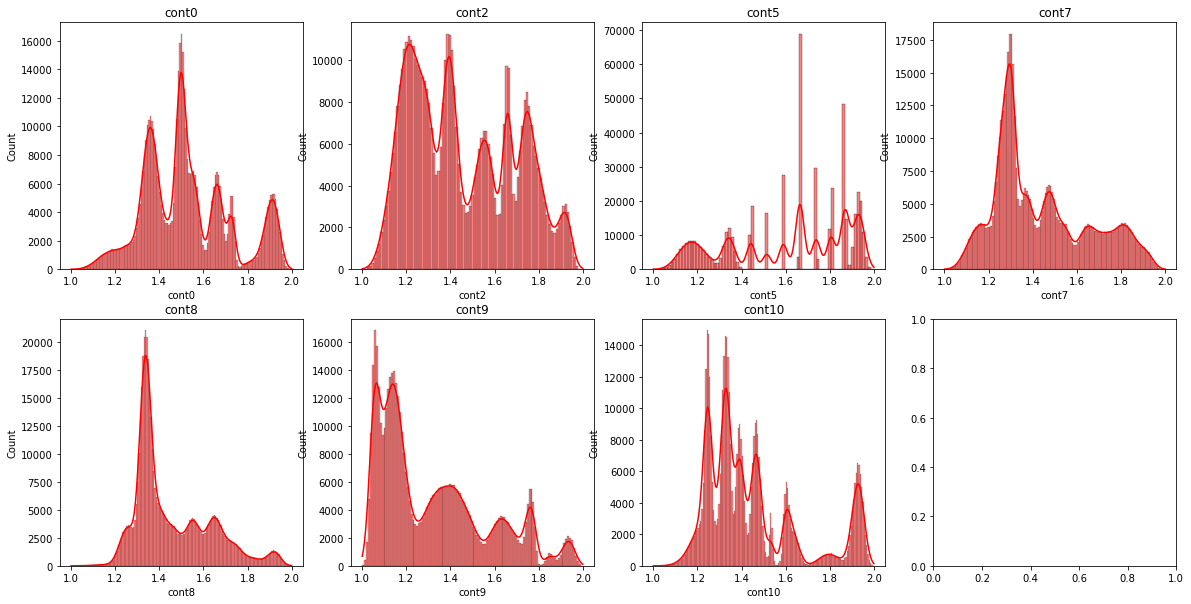

In [15]:
from scipy.stats import skew, boxcox
import seaborn as sns

data_numerical_TR_pd = data_numerical_norm_pd.copy()
data_categorical_TR_pd = data_categorical_norm_pd.copy()

skew_feature_list = []
for feature in data_numerical_norm_pd.columns:
    skew_value = skew(data_numerical_norm_pd[feature])
    if abs(skew_value) > 0.3:
        _, fitted_lambda = boxcox(data_numerical_norm_pd[feature])
        data_numerical_TR_pd[feature] = data_numerical_norm_pd[feature] ** fitted_lambda
        skew_feature_list.append(feature)
        
n_rows = round(data_numerical_TR_pd.shape[1] / 4)
n_rows = n_rows - 1
fig, axs = plt.subplots(nrows=n_rows, ncols=4, figsize=(20, 10))
index = 0
for i in range(n_rows):
    for j in range(4):
        try:
            sns.histplot(data_numerical_norm_pd[skew_feature_list[index]], kde = True, color = 'red', stat = 'count', ax=axs[i][j])
            axs[i][j].title.set_text(skew_feature_list[index])
        except:
            break
        index = index + 1
plt.show()

# Feature Selection

# Preparation Data For Training

In [16]:
from sklearn.model_selection import train_test_split

X = pd.concat([data_numerical_TR_pd[:][:train_rows_len], data_categorical_TR_pd[:][:train_rows_len]], axis=1)
X_test = pd.concat([data_numerical_TR_pd[:][train_rows_len:], data_categorical_TR_pd[:][train_rows_len:]], axis=1)
y = train_y.copy()

print('X shape: ', X.shape)
print('X_test shape: ', X_test.shape)
print('y shape: ', y.shape)
print(X.head())

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, train_y, random_state=42)

X shape:  (300000, 68)
X_test shape:  (200000, 68)
y shape:  (300000,)
      cont0     cont1     cont2     cont3     cont4     cont5     cont6  \
0  0.771882  1.831469  0.757355  1.831778  1.734982  3.604859  1.614927   
1  0.839769  1.263666  0.868692  1.580342  1.315982  2.338180  1.623011   
2  0.803225  1.257000  0.884926  1.654517  1.894852  3.244596  1.367991   
3  0.709523  1.672173  0.740416  1.843903  1.903929  3.591256  1.233940   
4  0.876465  1.204973  0.886647  1.319137  1.632942  1.481867  1.601123   

      cont7     cont8     cont9  ...  cat11cat12M  cat11cat13M  cat11cat14M  \
0  0.417356  0.158744  0.256644  ...            0            0            0   
1  0.633500  0.362071  0.269906  ...            0            0            0   
2  0.649517  0.351679  0.825885  ...            0            0            0   
3  0.378396  0.221788  0.343216  ...            0            0            0   
4  0.751206  0.404527  0.713877  ...            0            0            0   

   

# Model Creating and Evaluating

In [17]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def scorer(y, y_pred):
    return roc_auc_score(y, y_pred)

In [18]:
# XGBClassifier
xgbc_model = XGBClassifier(min_child_weight=0.1, reg_lambda=100, booster='gbtree', objective='binary:logitraw', random_state=42)
xgbc_score = cross_val_score(xgbc_model, train_X, train_y, scoring='roc_auc', cv=5)
print('xgbc_score: ', xgbc_score.mean())

# LGBMClassifier
ligthgbmc_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)
ligthgbmc_score = cross_val_score(ligthgbmc_model, train_X, train_y, scoring='roc_auc', cv=5)
print('ligthgbmc_score: ', ligthgbmc_score.mean())

# CatBoostClassifier
cbc_model = CatBoostClassifier(loss_function='Logloss', random_state=42, verbose=False)
cbc_score = cross_val_score(cbc_model, train_X, train_y, scoring='roc_auc', cv=5)
print('cbc_score: ', cbc_score.mean())

xgbc_score:  0.8897055453333407
ligthgbmc_score:  0.8879385374274603
cbc_score:  0.8910348176323944


# XGB Optuna

In [19]:
def objective(trial, data=X, target=y):
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 32),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_float('gamma', 0.0001, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'tree_method': 'gpu_hist',
        'booster': 'gbtree',
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'auc'

    }
    
    model = XGBClassifier(**params)  
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 333, verbose = False)
    y_pred = model.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

In [20]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=50)
#print('Number of finished trials: ', len(study.trials))
#print('Best trial: ', study.best_trial.params)
#print('Best value: ', study.best_value)

Number of finished trials:  1
Best trial:  {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 2616, 'min_child_weight': 36, 'gamma': 0.0001231342905079067, 'alpha': 5.138826788428377, 'lambda': 0.006952601632723477, 'colsample_bytree': 0.3019243613187322, 'subsample': 0.7474126793277557}
Best value:  0.8941200673933261

Number of finished trials:  50
Best trial:  {'max_depth': 6, 'learning_rate': 0.02, 'n_estimators': 2941, 'min_child_weight': 10, 'gamma': 0.027689264382343946, 'alpha': 2.239319562015662, 'lambda': 0.005116156806904708, 'colsample_bytree': 0.2018103901998171, 'subsample': 0.7452030806282816}
Best value:  0.8951492161710065

In [21]:
# Historic
#plot_optimization_history(study)

In [22]:
# Importance
#optuna.visualization.plot_param_importances(study)

# CatBoost Optuna

In [23]:
def objective(trial, data=X, target=y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 42,
        'task_type': 'GPU',
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'bootstrap_type': 'Poisson'
    }
    
    model = CatBoostClassifier(**params)  
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 222, verbose = False)
    y_pred = model.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

In [24]:
#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 50)
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)
#print('Best value:', study.best_value)

Number of finished trials: 50
Best trial: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 2877, 'max_bin': 200, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.09385107162927438, 'subsample': 0.7990428819543426}
Best value: 0.8925910141177894

In [25]:
# Historic
#plot_optimization_history(study)

In [26]:
# Importance
#optuna.visualization.plot_param_importances(study)

# LGBM Optuna

In [27]:
def objective(trial,data=X,target=y):   
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'cat_feature' : [x + len(data_numerical_TR_pd.columns) for x in range(len(data_categorical_TR_pd.columns))],
        'n_jobs' : -1, 
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'AUC',
        'device': 'gpu'
    }
    model = LGBMClassifier(**params)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='auc', early_stopping_rounds=300, verbose=False)
    
    preds = model.predict_proba(test_x)[:,1]
    
    auc = roc_auc_score(test_y, preds)
    
    return auc

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials: ', len(study.trials))
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

[I 2021-03-26 21:53:19,232] A new study created in memory with name: no-name-087f185a-5847-4832-9952-9ffdee97fad0
[I 2021-03-26 21:53:58,471] Trial 0 finished with value: 0.8946473620286988 and parameters: {'reg_alpha': 4.775641150066958, 'reg_lambda': 0.8260829062179963, 'num_leaves': 90, 'min_child_samples': 23, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 0.3725861763224062, 'n_estimators': 7839, 'cat_smooth': 76, 'cat_l2': 17, 'min_data_per_group': 67}. Best is trial 0 with value: 0.8946473620286988.
[I 2021-03-26 22:01:11,109] Trial 1 finished with value: 0.8964814783227606 and parameters: {'reg_alpha': 7.613137737853155, 'reg_lambda': 1.7067017416309835, 'num_leaves': 124, 'min_child_samples': 41, 'max_depth': 29, 'learning_rate': 0.005, 'colsample_bytree': 0.2956428034460056, 'n_estimators': 7838, 'cat_smooth': 73, 'cat_l2': 17, 'min_data_per_group': 165}. Best is trial 1 with value: 0.8964814783227606.
[I 2021-03-26 22:07:00,242] Trial 2 finished with value: 0.895

Number of finished trials:  50
Best trial:  {'reg_alpha': 9.039083788866368, 'reg_lambda': 0.06677046150992982, 'num_leaves': 201, 'min_child_samples': 7, 'max_depth': 39, 'learning_rate': 0.01, 'colsample_bytree': 0.26778097211367174, 'n_estimators': 4969, 'cat_smooth': 90, 'cat_l2': 20, 'min_data_per_group': 150}
Best value:  0.8965907954131382


Trial 32 finished with value: 0.8960118885713237 and parameters: {'reg_alpha': 5.028382776465415, 'reg_lambda': 7.969115943661513, 'num_leaves': 196, 'min_child_samples': 39, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.22772406492167746, 'n_estimators': 7028, 'cat_smooth': 38, 'cat_l2': 20, 'min_data_per_group': 199}. Best is trial 32 with value: 0.8960118885713237.

Number of finished trials: 50
Best trial: {'reg_alpha': 5.028382776465415, 'reg_lambda': 7.969115943661513, 'num_leaves': 196, 'min_child_samples': 39, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.22772406492167746, 'n_estimators': 7028, 'cat_smooth': 38, 'cat_l2': 20, 'min_data_per_group': 199}. Best is trial 32 with value: 0.8960118885713237.

In [29]:
# Historic
plot_optimization_history(study)

In [30]:
# Importance
optuna.visualization.plot_param_importances(study)

In [31]:
lgb_params =  {'reg_alpha': 5.028382776465415, 
               'reg_lambda': 7.969115943661513, 
               'num_leaves': 196, 
               'min_child_samples': 39, 
               'max_depth': 20, 
               'learning_rate': 0.01, 
               'colsample_bytree': 0.22772406492167746, 
               'n_estimators': 7028, 
               'cat_smooth': 38, 
               'cat_l2': 20, 
               'min_data_per_group': 199,
               'cat_feature' : [x + len(data_numerical_TR_pd.columns) for x in range(len(data_categorical_TR_pd.columns))],
               'n_jobs' : -1, 
               'random_state': 42,
               'boosting_type': 'gbdt',
               'metric': 'AUC',
               'device': 'gpu'
}

In [32]:
lgb_params = study.best_trial.params
lgb_params['device'] = "gpu"
lgb_params['random_state'] = 42
lgb_params['cat_feature'] = [x + len(data_numerical_TR_pd.columns) for x in range(len(data_categorical_TR_pd.columns))]
lgb_params['n_jobs'] = -1 
lgb_params['boosting_type'] =  'gbdt'
lgb_params['metric'] =  'AUC'

In [33]:
NFOLDS = 20
folds = StratifiedKFold(n_splits=NFOLDS, random_state=42, shuffle=True)
predictions = np.zeros(len(test))
for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print("--> Fold {}".format(fold + 1))
    
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    lgb_model = LGBMClassifier(**lgb_params).fit(X_train, y_train, 
                                                  eval_set=[(X_valid, y_valid)], 
                                                  eval_metric='auc', 
                                                  early_stopping_rounds=300, verbose=0)
    
    y_preds = lgb_model.predict_proba(X_valid)[:,1]
    predictions += lgb_model.predict_proba(X_test)[:,1] / folds.n_splits 
    
    print(": LGB - ROC AUC Score = {}".format(roc_auc_score(y_valid, y_preds, average="micro")))

--> Fold 1
: LGB - ROC AUC Score = 0.9020919089954955
--> Fold 2
: LGB - ROC AUC Score = 0.8922028124409456
--> Fold 3
: LGB - ROC AUC Score = 0.8960405198132649
--> Fold 4
: LGB - ROC AUC Score = 0.8958802149386386
--> Fold 5
: LGB - ROC AUC Score = 0.8990421218805061
--> Fold 6
: LGB - ROC AUC Score = 0.8941231840359992
--> Fold 7
: LGB - ROC AUC Score = 0.8991078598897505
--> Fold 8
: LGB - ROC AUC Score = 0.8967561739118208
--> Fold 9
: LGB - ROC AUC Score = 0.8989371236712962
--> Fold 10
: LGB - ROC AUC Score = 0.900417507118365
--> Fold 11
: LGB - ROC AUC Score = 0.8971879904600452
--> Fold 12
: LGB - ROC AUC Score = 0.8955519814063692
--> Fold 13
: LGB - ROC AUC Score = 0.8961527309429336
--> Fold 14
: LGB - ROC AUC Score = 0.9009863006782132
--> Fold 15
: LGB - ROC AUC Score = 0.8941482694777214
--> Fold 16
: LGB - ROC AUC Score = 0.8961178761026154
--> Fold 17
: LGB - ROC AUC Score = 0.9018513717936143
--> Fold 18
: LGB - ROC AUC Score = 0.8970754369449119
--> Fold 19
: LGB - 

In [34]:
sub = pd.read_csv('../input/tabular-playground-series-mar-2021/sample_submission.csv')
sub['target'] = predictions
regr_table = sub.to_csv("Sub_lgb_v2.csv", index = False)